In [1]:
import rebound as rb
import numpy as np
from celmech import Poincare,PoincareHamiltonian
from sympy import init_printing
import matplotlib.pyplot as plt
import pickle

init_printing()

from sympy import symbols

from sympy import S,diff

In [2]:
from celmech.nbody_simulation_utilities import get_simarchive_integration_results

In [3]:
import pandas as pd

datafile = "/Users/shadden/Projects/00_Codes_And_Data/HL17_Posteriors/Kepler-60_high_mass_priors.pkl"
df = pd.read_pickle(datafile)

In [5]:
import rebound as rb

def get_sim(dfrow):
    sim = rb.Simulation()
    sim.add(m=1)
    for i in range(3):
        sim.add(
            m = dfrow['mu{}'.format(i)],
            P = dfrow['per{}'.format(i)],
            e = dfrow['e{}'.format(i)],
            pomega = dfrow['pomega{}'.format(i)],
            l = dfrow['mean_long{}'.format(i)]
        )
    return sim



In [6]:
with open("./Kepler_60_MCMC_median_param_values.pkl","rb") as fi:
    medians = pickle.load(fi)

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1242b5a90>)

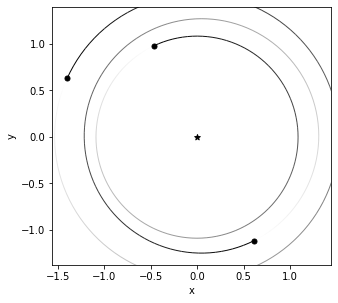

In [7]:
np.random.seed(1)
sim = rb.Simulation()
sim.add(m=1)
for i in range(3):
    sim.add(
        m = medians['mu{}'.format(i)],
        P = medians['per{}'.format(i)],
        e = medians['e{}'.format(i)],
        l = medians['mean_long{}'.format(i)],
        pomega = medians['pomega{}'.format(i)]
#         Omega = np.random.uniform(0,2*np.pi),
#         inc = np.random.rayleigh(0.01)
    )
rb.OrbitPlot(sim)

In [8]:
from celmech.nbody_simulation_utilities import get_simarchive_integration_results
from celmech.nbody_simulation_utilities import set_timestep

In [45]:
sim = get_sim(df.iloc[0])
sim.integrator = 'whfast'
sim.ri_whfast.safe_mode=0
set_timestep(sim,1/40)
sim.automateSimulationArchive("./kepler60_sa.bin",interval=10 * sim.particles[1].P ,deletefile=True)

In [46]:
%time sim.integrate(5e3 * sim.particles[1].P)

CPU times: user 177 ms, sys: 122 ms, total: 299 ms
Wall time: 2.03 s


In [47]:
sa = rb.SimulationArchive("./kepler60_sa.bin")

In [48]:
nbody_results = get_simarchive_integration_results(sa)

In [49]:
from celmech.disturbing_function import DFCoeff_C
from celmech.disturbing_function import eval_DFCoeff_dict

In [50]:
f = eval_DFCoeff_dict(DFCoeff_C(5,-4,-1,0,0,0,0,0,0,0),(4/5)**(2/3))
g = eval_DFCoeff_dict(DFCoeff_C(5,-4,0,-1,0,0,0,0,0,0),(4/5)**(2/3))
nbody_results['z'] = nbody_results['e'] * np.exp(1j * nbody_results['pomega'])
capZ12 = np.array([f,g,0]) @ nbody_results['z']

f = eval_DFCoeff_dict(DFCoeff_C(4,-3,-1,0,0,0,0,0,0,0),(3/4)**(2/3))
g = eval_DFCoeff_dict(DFCoeff_C(4,-3,0,-1,0,0,0,0,0,0),(3/4)**(2/3))

capZ23 = np.array([0,f,g]) @ nbody_results['z']

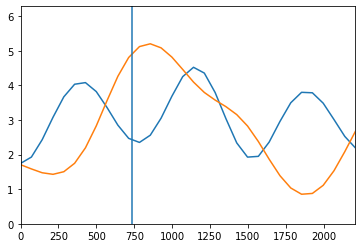

In [53]:
phi12 = np.mod(np.array([-4,5,0]) @ nbody_results['l'] - np.angle(capZ12),2*np.pi)
phi23 = np.mod(np.array([0,-3,4]) @ nbody_results['l'] - np.angle(capZ23),2*np.pi)
plt.plot(nbody_results['time'],phi12,'-')
plt.plot(nbody_results['time'],phi23,'-')
plt.ylim(0,2*np.pi)
plt.axvline(Tlib)
plt.xlim(0,3 * Tlib)

In [18]:
sim = sa[0]

pvars = Poincare.from_Simulation(sim)
pham = PoincareHamiltonian(pvars)

pham.add_all_MMR_and_secular_terms(5,1,max_order=2,indexIn=1,indexOut=2)
pham.add_all_MMR_and_secular_terms(4,1,max_order=2,indexIn=2,indexOut=3)
pham.add_all_secular_terms(2,indexIn=1,indexOut=3)

N = 512
lP,eP,pomegaP = np.zeros((3,pvars.N-1,N))
times = np.linspace(0,10e4,N)
for i,t in enumerate(times):
    pham.integrate(t)
    for j,p in enumerate(pvars.particles[1:]):
        lP[j,i] = p.l
        eP[j,i] = p.e
        pomegaP[j,i] = p.pomega

In [19]:
zP = eP * np.exp(1j * pomegaP)
f = eval_DFCoeff_dict(DFCoeff_C(5,-4,-1,0,0,0,0,0,0,0),(4/5)**(2/3))
g = eval_DFCoeff_dict(DFCoeff_C(5,-4,0,-1,0,0,0,0,0,0),(4/5)**(2/3))
capZ12P = np.array([f,g,0]) @ zP
phi12P = np.mod(np.array([-4,5,0]) @ lP - np.angle(capZ12P),2*np.pi)

In [20]:
zP = eP * np.exp(1j * pomegaP)
f = eval_DFCoeff_dict(DFCoeff_C(4,-3,-1,0,0,0,0,0,0,0),(3/4)**(2/3))
g = eval_DFCoeff_dict(DFCoeff_C(4,-3,0,-1,0,0,0,0,0,0),(3/4)**(2/3))
capZ23P = np.array([0,f,g]) @ zP
phi23P = np.mod(np.array([0,-3,4]) @ lP - np.angle(capZ23P),2*np.pi)

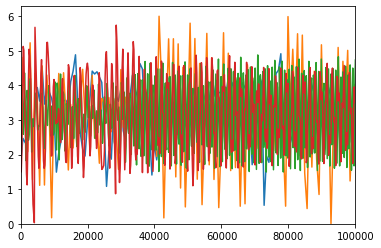

In [22]:
phi12 = np.mod(np.array([-4,5,0]) @ nbody_results['l'] - np.angle(capZ12),2*np.pi)
phi23 = np.mod(np.array([0,-3,4]) @ nbody_results['l'] - np.angle(capZ23),2*np.pi)
plt.plot(nbody_results['time'],phi12,'-')
plt.plot(nbody_results['time'],phi23,'-')
plt.ylim(0,2*np.pi)
plt.plot(times,phi12P)
plt.plot(times,phi23P)
plt.xlim(0,times[-1])

In [76]:
from celmech.symplectic_evolution_opertaors import FirstOrderEccentricityResonanceOperator
from celmech.symplectic_evolution_opertaors import KeplerianEvolutionOperator
from celmech.symplectic_evolution_opertaors import LinearSecularEvolutionOperator
from celmech.symplectic_evolution_opertaors import get_res_chain_reference_Lambdas_and_semimajor_axes

sim = sa[0]
pvars = Poincare.from_Simulation(sim)

from celmech import Andoyer

avars = Andoyer.from_Poincare(pvars,5,1,sim.particles[1].a,1,2)
Tlib = avars.tlib

dt = Tlib / 20

aref,Lref = get_res_chain_reference_Lambdas_and_semimajor_axes(pvars,[4,3])
kepOp = KeplerianEvolutionOperator(pvars,dt/2)
secOp = LinearSecularEvolutionOperator(pvars,dt/2)
resOp12 = FirstOrderEccentricityResonanceOperator(pvars,dt,5,1,2,Lref)
resOp23 = FirstOrderEccentricityResonanceOperator(pvars,dt/2,4,2,3,Lref)

def step():
    kepOp.apply()
    secOp.apply()
    resOp23.apply()
    resOp12.apply()
    resOp23.apply()
    secOp.apply()
    kepOp.apply()
    
def run():
    Nstep = int(sa[-1].t//dt)
    lS,eS,pomegaS = np.zeros((3,pvars.N-1,Nstep))
    times = np.zeros(Nstep)
    for i in range(Nstep):
        times[i] = i * dt
        for j,p in enumerate(pvars.particles[1:]):
            lS[j,i] = p.l
            eS[j,i] = p.e
            pomegaS[j,i] = p.pomega        
        step()
    return times,lS,eS,pomegaS

In [77]:
%time timesS,lS,eS,pomegaS = run()

CPU times: user 451 ms, sys: 8.07 ms, total: 459 ms
Wall time: 460 ms


In [78]:
zS = eS * np.exp(1j * pomegaS)
f = eval_DFCoeff_dict(DFCoeff_C(5,-4,-1,0,0,0,0,0,0,0),(4/5)**(2/3))
g = eval_DFCoeff_dict(DFCoeff_C(5,-4,0,-1,0,0,0,0,0,0),(4/5)**(2/3))
capZ12S = np.array([f,g,0]) @ zS
phi12S = np.mod(np.array([-4,5,0]) @ lS - np.angle(capZ12S),2*np.pi)

In [79]:
zS = eS * np.exp(1j * pomegaS)
f = eval_DFCoeff_dict(DFCoeff_C(4,-3,-1,0,0,0,0,0,0,0),(3/4)**(2/3))
g = eval_DFCoeff_dict(DFCoeff_C(4,-3,0,-1,0,0,0,0,0,0),(3/4)**(2/3))
capZ23S = np.array([0,f,g]) @ zS
phi23S = np.mod(np.array([0,-3,4]) @ lS - np.angle(capZ23S),2*np.pi)

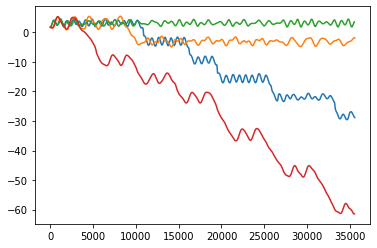

In [81]:
phi12 = np.mod(np.array([-4,5,0]) @ nbody_results['l'] - np.angle(capZ12),2*np.pi)
phi23 = np.mod(np.array([0,-3,4]) @ nbody_results['l'] - np.angle(capZ23),2*np.pi)
plt.plot(nbody_results['time'],np.unwrap(phi12),'-')
plt.plot(nbody_results['time'],np.unwrap(phi23),'-')
#plt.ylim(0,2*np.pi)
plt.plot(timesS,np.unwrap(phi12S))
plt.plot(timesS,np.unwrap(phi23S))
#plt.xlim(0,30 * Tlib) #timesS[-1])

# Hamiltonian
Print the symbolic Hamiltonian of the system

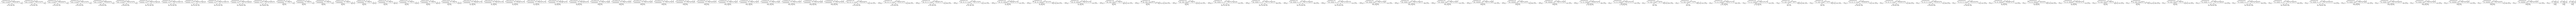

In [8]:
pham.H.expand()

In [9]:
times = np.linspace()

# Matrix entries of the canonical equations

$$
\frac{d}{dt}\begin{pmatrix}\eta_1 \\ \kappa_1 \\ ... \\ \rho_1 \\ \sigma_1 \\... \end{pmatrix}
= \begin{pmatrix}\frac{\partial H}{\partial \kappa_1}\\ -\frac{\partial H}{\partial \eta_1} \\ ... \\ \frac{\partial H}{\partial \sigma_1}\\ -\frac{\partial H}{\partial \rho_1}  \\... \end{pmatrix} = \Omega \cdot\left(\nabla H({e=0,I=0}) +  \Omega\cdot\nabla^2H \cdot \begin{pmatrix}\eta_1 \\ \kappa_1 \\ ... \\ \rho_1 \\ \sigma_1 \\... \end{pmatrix} + ...\right)
$$ 

As an example, lets get a few terms of $d\eta_1/dt$

In [9]:
from sympy import substitution

In [10]:
eta1dot = pham.derivs[S('eta1')]

In [11]:
ecc_and_inc_indices=[]
for i in range(pham.N-1):
    ecc_and_inc_indices += [6*i,6*i+1,6*i+4, 6*i+5]

In [12]:
set_ecc_and_inc_zero_dict = {pham.varsymbols[i]:0. for i in ecc_and_inc_indices}

## constant term on r.h.s.

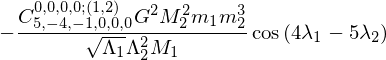

In [13]:
eta1dot.subs(set_ecc_and_inc_zero_dict)

## diagonal element of $\nabla^2H$

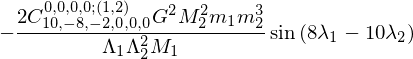

In [14]:
diff(pham.derivs[S('eta1')],S('eta1'))

## some other term...

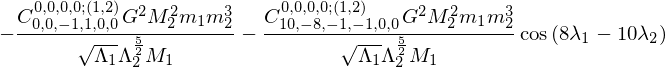

In [15]:
diff(pham.derivs[S('eta1')],S('kappa2'))

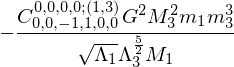

In [17]:
diff(pham.derivs[S('eta1')],S('kappa3'))